<a href="https://colab.research.google.com/github/hamagami/ad2025/blob/main/PatchCore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# =====================================================
# セル1: MVTec AD を mydrive 直リンクからダウンロード＆展開（Drive不要）
# - TARGET="all" なら全体 (~5GB)
# - それ以外はクラス名（例: "bottle"）のみをダウンロード
# - 展開先: /content/mvtec_anomaly_detection/<class>/...
# - 互換リンク: /content/mvtec -> /content/mvtec_anomaly_detection
# =====================================================

import os, subprocess, tarfile, zipfile, glob

TARGET = "bottle"  # "all" または 15クラス名のいずれか: bottle,cable,capsule,carpet,grid,hazelnut,leather,metal_nut,pill,screw,tile,toothbrush,transistor,wood,zipper
DEST_PARENT = "/content"
DEST_ROOT   = os.path.join(DEST_PARENT, "mvtec_anomaly_detection")
COMP_LINK   = "/content/mvtec"  # 互換リンク

WHOLE_URL = "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938113-1629952094/mvtec_anomaly_detection.tar.xz"
CLASS_URLS = {
    "bottle":      "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937370-1629951468/bottle.tar.xz",
    "cable":       "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937413-1629951498/cable.tar.xz",
    "capsule":     "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937454-1629951595/capsule.tar.xz",
    "carpet":      "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937484-1629951672/carpet.tar.xz",
    "grid":        "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937487-1629951814/grid.tar.xz",
    "hazelnut":    "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937545-1629951845/hazelnut.tar.xz",
    "leather":     "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937607-1629951964/leather.tar.xz",
    "metal_nut":   "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937637-1629952063/metal_nut.tar.xz",
    "pill":        "https://www.mydrive.ch/shares/43421/11a215a5749fcfb75e331ddd5f8e43ee/download/420938129-1629953099/pill.tar.xz",
    "screw":       "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938130-1629953152/screw.tar.xz",
    "tile":        "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938133-1629953189/tile.tar.xz",
    "toothbrush":  "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938134-1629953256/toothbrush.tar.xz",
    "transistor":  "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938166-1629953277/transistor.tar.xz",
    "wood":        "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938383-1629953354/wood.tar.xz",
    "zipper":      "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938385-1629953449/zipper.tar.xz",
}
IMG_EXTS = ('*.png','*.jpg','*.jpeg','*.bmp','*.tif','*.tiff')

def run(cmd):
    print("[RUN]", cmd)
    rc = subprocess.call(cmd, shell=True)
    if rc != 0:
        raise RuntimeError(f"Command failed (rc={rc}): {cmd}")

def list_images_multi_ext(dirpath: str):
    files=[]
    for ext in IMG_EXTS:
        files += glob.glob(os.path.join(dirpath, '**', ext), recursive=True)
    return sorted(files)

os.makedirs(DEST_ROOT, exist_ok=True)

if TARGET == "all":
    tar_path = os.path.join(DEST_PARENT, "mvtec_ad.tar.xz")
    run(f'wget --progress=dot:mega -O "{tar_path}" "{WHOLE_URL}"')
    run(f'tar -xf "{tar_path}" -C "{DEST_PARENT}"')
else:
    if TARGET not in CLASS_URLS:
        raise ValueError(f"Unknown TARGET='{TARGET}'.")
    tar_path = os.path.join(DEST_PARENT, f"{TARGET}.tar.xz")
    run(f'wget --progress=dot:mega -O "{tar_path}" "{CLASS_URLS[TARGET]}"')
    run(f'tar -xf "{tar_path}" -C "{DEST_ROOT}"')

# 互換リンク（/content/mvtec）が無ければ作成
if not os.path.exists(COMP_LINK):
    try:
        os.symlink(DEST_ROOT, COMP_LINK)
        print("[INFO] Symlink:", COMP_LINK, "->", DEST_ROOT)
    except Exception as e:
        print("[WARN] symlink failed:", e)

# 簡易チェック＆要約
def quick_summary(root_parent="/content"):
    candidates = ["/content/mvtec", "/content/mvtec_anomaly_detection"]
    ok = False
    for base in candidates:
        if not os.path.isdir(base): continue
        classes = [d for d in os.listdir(base) if os.path.isdir(os.path.join(base, d))]
        classes = sorted([c for c in classes if os.path.isdir(os.path.join(base,c,"test")) or os.path.isdir(os.path.join(base,c,"train"))])
        if not classes: continue
        print(f"[READY] Found classes under {base}: {classes[:10]}{' ...' if len(classes)>10 else ''}")
        # 1クラスだけ簡易枚数
        cls0 = classes[0]
        tg = os.path.join(base, cls0, "train", "good")
        ttg= os.path.join(base, cls0, "test",  "good")
        n_tg = len(list_images_multi_ext(tg)) if os.path.isdir(tg) else 0
        n_ttg= len(list_images_multi_ext(ttg)) if os.path.isdir(ttg) else 0
        print(f"[SUMMARY] sample class={cls0}: train/good={n_tg}, test/good={n_ttg}")
        ok = True
    if not ok:
        raise FileNotFoundError("Extraction finished but dataset layout not detected. Please check archive.")
    print("[DONE] MVTec AD is ready under /content/mvtec_anomaly_detection")

quick_summary()


[RUN] wget --progress=dot:mega -O "/content/bottle.tar.xz" "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937370-1629951468/bottle.tar.xz"
[RUN] tar -xf "/content/bottle.tar.xz" -C "/content/mvtec_anomaly_detection"
[INFO] Symlink: /content/mvtec -> /content/mvtec_anomaly_detection
[READY] Found classes under /content/mvtec: ['bottle']
[SUMMARY] sample class=bottle: train/good=209, test/good=20
[READY] Found classes under /content/mvtec_anomaly_detection: ['bottle']
[SUMMARY] sample class=bottle: train/good=209, test/good=20
[DONE] MVTec AD is ready under /content/mvtec_anomaly_detection


[Device] cpu
[SUMMARY] {'root': '/content/mvtec', 'class': 'bottle', 'train/good': 209, 'test/good': 20, 'test/anoms': 63, 'anomaly_types': ['contamination', 'broken_small', 'broken_large']}
[INFO] train=189 | val=20 | test=83 
Downloading: "https://download.pytorch.org/models/wide_resnet50_2-9ba9bcbe.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-9ba9bcbe.pth


100%|██████████| 263M/263M [00:16<00:00, 16.9MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[BANK] collected patches: torch.Size([11340, 1536])
[BANK] coreset selected: 3000 / 11340
[FAISS] unavailable, fallback to torch.cdist. Reason: ModuleNotFoundError("No module named 'faiss'")
[RESULT] PatchCore Image AUROC=1.0000 | Pixel AUROC=0.9748


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[THRESH] tau = 0.210253

[CONFUSION MATRIX] (rows=true, cols=pred) labels=[good(0), anomaly(1)]
[[19  1]
 [ 0 63]]

[REPORT]
              precision    recall  f1-score   support

        good     1.0000    0.9500    0.9744        20
     anomaly     0.9844    1.0000    0.9921        63

    accuracy                         0.9880        83
   macro avg     0.9922    0.9750    0.9832        83
weighted avg     0.9881    0.9880    0.9878        83


[SHOW] Top-8 predicted anomalies (by PatchCore score)


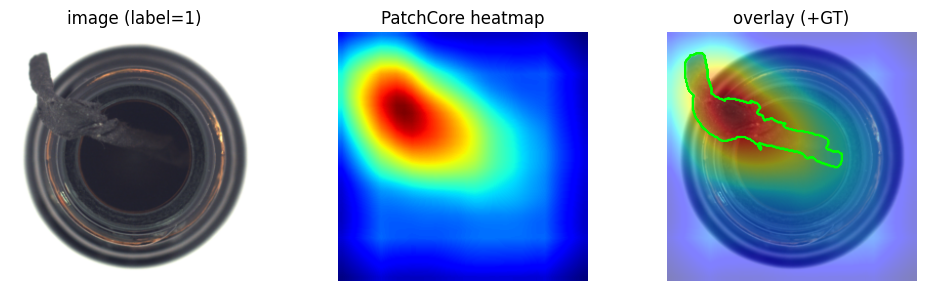

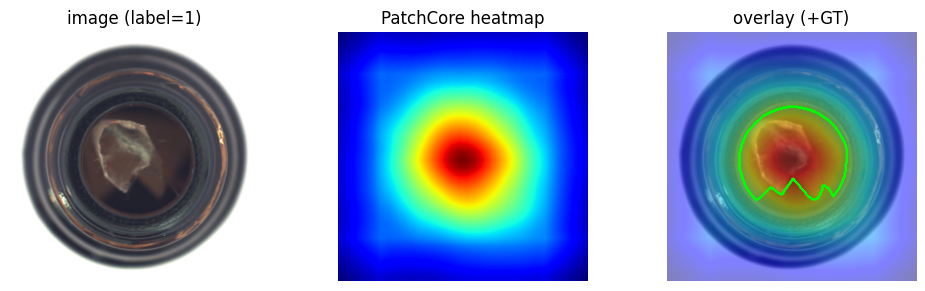

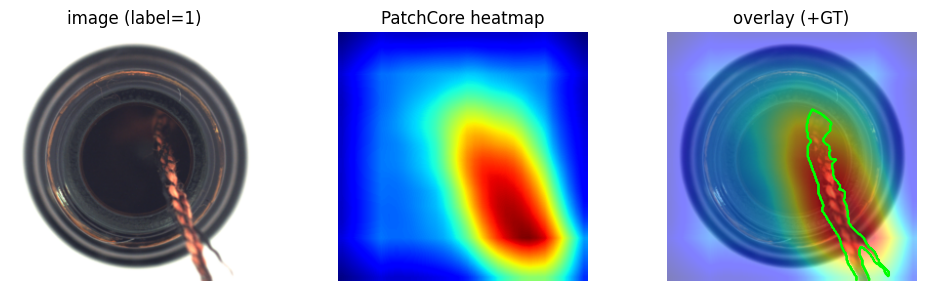

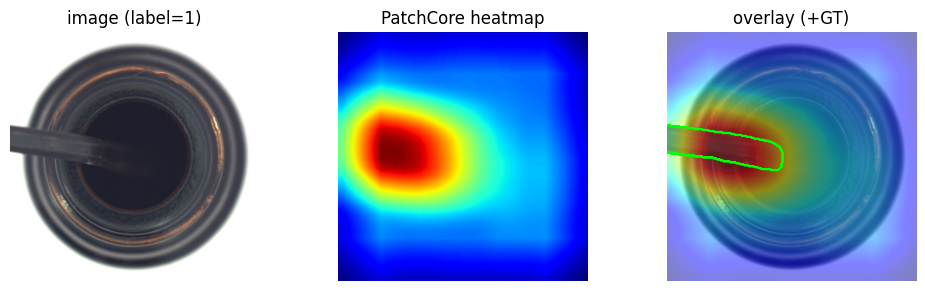

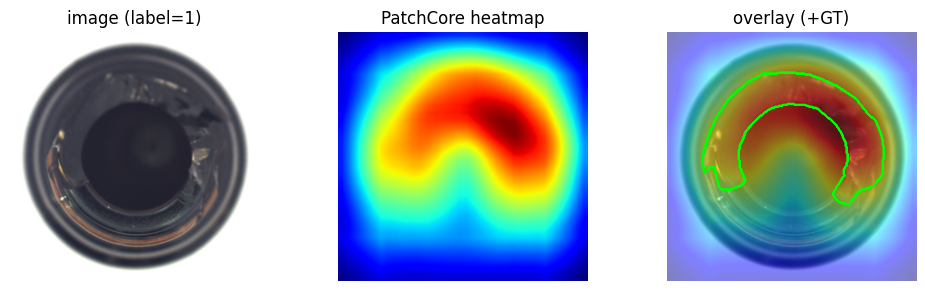

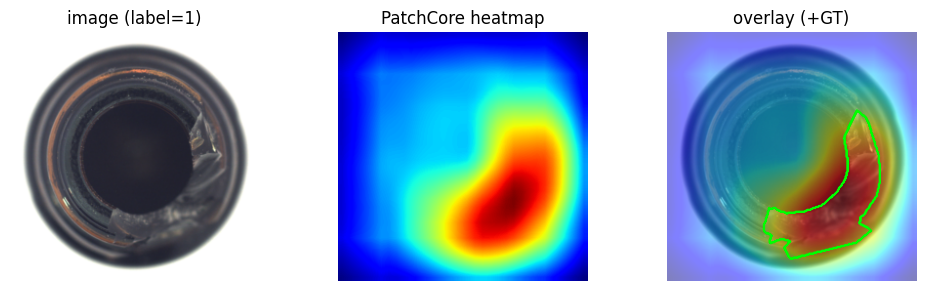

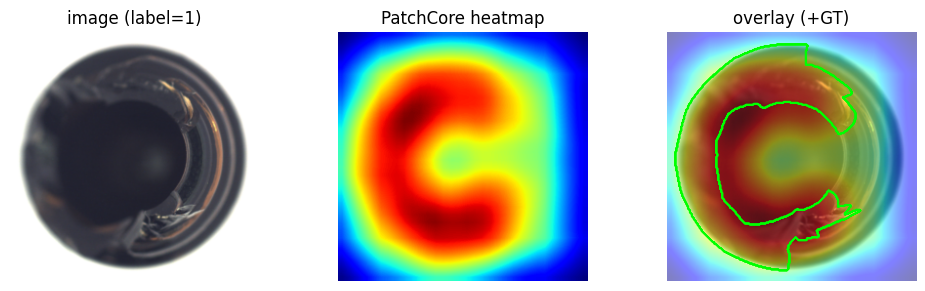

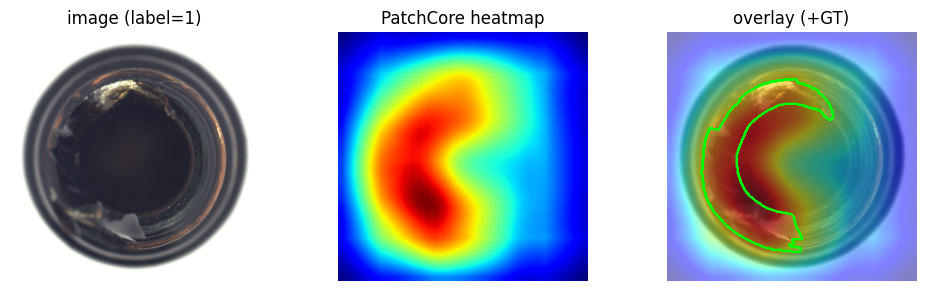


[SHOW] FP examples (pred=1,true=0): [69]


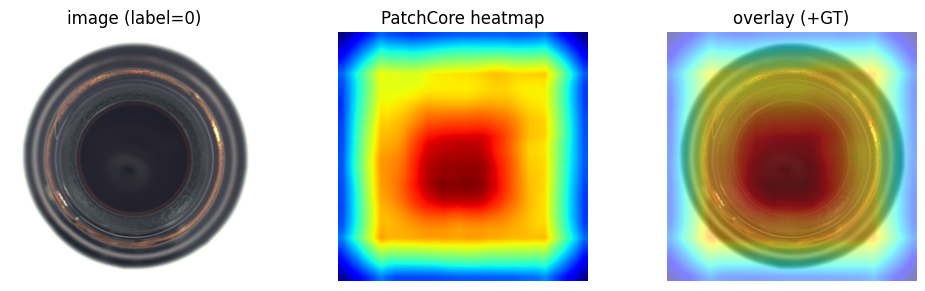


[SHOW] FN examples (pred=0,true=1): []

[SHOW] one normal example: idx=63


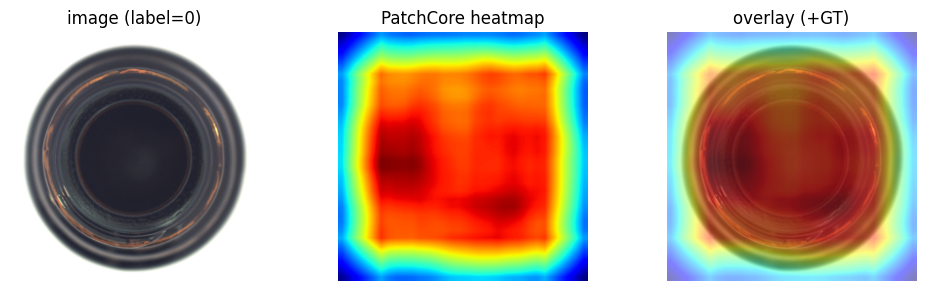


[DONE] 可視化PNGは: ./out_patchcore/vis_bottle


In [2]:
# =====================================================
# PatchCore (MVTec AD) 1セル完結版
# - WRN50-2 の layer2/3 特徴を 32x32 に整列→連結→L2正規化
# - train/good からパッチ特徴を収集→サブサンプリング→k-center greedy でコアセット構築
# - kNN距離で異常度マップ→画像スコア→AUROC（画像/ピクセル）
# - 閾値（val-good 99.5%）で判定、混同行列/レポート、可視化PNG保存
# =====================================================

import os, glob, math, random
from typing import List, Tuple
import numpy as np
from PIL import Image

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# ---------------- 基本設定 ----------------
CLASS_NAME = "bottle"   # ダウンロード済みクラスに合わせる
IMG_SIZE   = 256
CROP_SIZE  = 256
GRID_SIZE  = 32         # 特徴マップ解像度
TOP_P      = 0.01       # 画像スコアで使う上位p%
BLUR_KERNEL= 11
BATCH      = 8          # 特徴抽出時のバッチ（VRAMに応じて）
NUM_WORKERS= 2
SEED=42

# メモリバンク設定
MEM_SAMPLES_PER_IMAGE = 60     # 画像あたり採るパッチ数（例：60）
CORESET_SIZE          = 3000   # k-center greedy で最終的に残す数（~1k-5k）
K_NEIGHBORS           = 5      # kNNのk（1〜9あたり）
USE_FAISS             = True   # faiss が入っていれば自動で使う

OUT_DIR_PATCHCORE = "./out_patchcore"

# 乱数とデバイス
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic=True; torch.backends.cudnn.benchmark=False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('[Device]', device)

# ------- 共通ユーティリティ / データセット（UNet/PaDiMと同等） -------
IMG_EXTS = ('*.png','*.jpg','*.jpeg','*.bmp','*.tif','*.tiff')
def list_images_multi_ext(dirpath: str) -> List[str]:
    files=[]
    for ext in IMG_EXTS:
        files += glob.glob(os.path.join(dirpath, '**', ext), recursive=True)
    return sorted(files)

def autodetect_root(class_name: str):
    if 'ROOT_OVERRIDE' in globals() and os.path.isdir(os.path.join(ROOT_OVERRIDE, class_name)):
        return ROOT_OVERRIDE
    candidates = ["/content/mvtec", "/content/mvtec_anomaly_detection", "/content", "/kaggle/input"]
    for root in candidates:
        tg = os.path.join(root, class_name, "train", "good")
        ttg= os.path.join(root, class_name, "test",  "good")
        if os.path.isdir(tg) and len(list_images_multi_ext(tg))>0: return root
        if os.path.isdir(ttg) and len(list_images_multi_ext(ttg))>0: return root
    for base in ["/content", "/kaggle/input"]:
        for path in glob.glob(os.path.join(base, "**", class_name), recursive=True):
            tg = os.path.join(path, "train", "good")
            ttg= os.path.join(path, "test",  "good")
            if (os.path.isdir(tg) and len(list_images_multi_ext(tg))>0) or (os.path.isdir(ttg) and len(list_images_multi_ext(ttg))>0):
                return os.path.dirname(path)
    raise FileNotFoundError(f"Dataset class '{class_name}' not found under /content. Run the download cell first.")

def print_dataset_summary(root, cls):
    tg  = os.path.join(root, cls, 'train', 'good')
    ttg = os.path.join(root, cls, 'test',  'good')
    tdir= os.path.join(root, cls, 'test')
    def _c(p): return len(list_images_multi_ext(p)) if os.path.isdir(p) else 0
    subs = [d for d in os.listdir(tdir) if os.path.isdir(os.path.join(tdir, d)) and d!='good'] if os.path.isdir(tdir) else []
    n_an = sum(_c(os.path.join(tdir, s)) for s in subs) if subs else 0
    print('[SUMMARY]', {'root':root, 'class':cls, 'train/good':_c(tg), 'test/good':_c(ttg), 'test/anoms':n_an, 'anomaly_types':subs})

class MVTecTrain(Dataset):
    def __init__(self, root: str, cls: str, img_size: int, crop_size: int, val_split: float=0.1, is_val: bool=False):
        tg = os.path.join(root, cls, 'train', 'good')
        files = list_images_multi_ext(tg)
        self.used_test_good = False
        if len(files) == 0:
            ttg = os.path.join(root, cls, 'test', 'good')
            files = list_images_multi_ext(ttg)
            if len(files) == 0:
                raise FileNotFoundError(f"No images in train/good nor test/good under root={root}, class={cls}")
            print('[WARN] train/good missing → using test/good for training (evaluation leakage risk).')
            self.used_test_good = True
        n_val = max(1, int(len(files)*val_split))
        self.files = files[:n_val] if is_val else files[n_val:]
        self.t = transforms.Compose([transforms.Resize(img_size), transforms.CenterCrop(crop_size), transforms.ToTensor()])
    def __len__(self): return len(self.files)
    def __getitem__(self, i):
        return self.t(Image.open(self.files[i]).convert('RGB'))

class MVTecTest(Dataset):
    def __init__(self, root: str, cls: str, img_size: int, crop_size: int, exclude_good_if_leak=False):
        test_dir = os.path.join(root, cls, 'test'); gt_dir = os.path.join(root, cls, 'ground_truth')
        if not os.path.isdir(test_dir): raise FileNotFoundError(f'Not found: {test_dir}')
        subdirs = sorted([d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))])
        self.items=[]
        for sd in subdirs:
            if exclude_good_if_leak and sd=='good': continue
            for ip in list_images_multi_ext(os.path.join(test_dir, sd)):
                if sd=='good':
                    self.items.append((ip, None, 0))
                else:
                    base = os.path.splitext(os.path.basename(ip))[0]
                    mp = os.path.join(gt_dir, sd, base + '_mask.png')
                    if not os.path.exists(mp):
                        cand = glob.glob(os.path.join(gt_dir, sd, '*_mask.png'))
                        mp = cand[0] if len(cand)>0 else mp
                    self.items.append((ip, mp, 1))
        assert len(self.items)>0, f'No test images in {test_dir}'
        self.ti = transforms.Compose([transforms.Resize(img_size), transforms.CenterCrop(crop_size), transforms.ToTensor()])
        self.tm = transforms.Compose([transforms.Resize(img_size, interpolation=Image.NEAREST),
                                      transforms.CenterCrop(crop_size), transforms.PILToTensor()])
    def __len__(self): return len(self.items)
    def __getitem__(self, i):
        ip, mp, y = self.items[i]
        img = self.ti(Image.open(ip).convert('RGB'))
        if mp is None:
            mask = torch.zeros(1, img.shape[1], img.shape[2], dtype=torch.uint8)
        else:
            mask = self.tm(Image.open(mp).convert('L')); mask = (mask>0).to(torch.uint8)
        return img, mask, y

# ----------------- Feature extractor (WideResNet50-2) -----------------
class WRNFeat(nn.Module):
    """wide_resnet50_2 の layer2/3 を使う（PatchCore既定に近い）。"""
    def __init__(self, grid=GRID_SIZE):
        super().__init__()
        # 重みロード
        backbone = None
        try:
            weights = models.Wide_ResNet50_2_Weights.IMAGENET1K_V2
            backbone = models.wide_resnet50_2(weights=weights)
        except Exception:
            try:
                backbone = models.wide_resnet50_2(pretrained=True)
            except Exception:
                print("[WARN] Pretrained weights unavailable. Using random init.")
                backbone = models.wide_resnet50_2(weights=None)
        self.b = backbone.eval().to(device)
        for p in self.b.parameters(): p.requires_grad_(False)

        self.grid = grid
        self._feats = []
        def hk(_, __, out): self._feats.append(out)
        self.b.layer2.register_forward_hook(hk)
        self.b.layer3.register_forward_hook(hk)

        self.tnorm = transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])

    @torch.no_grad()
    def forward(self, x):
        self._feats.clear()
        # stem〜layer3まで通す
        _ = self.b.maxpool(self.b.relu(self.b.bn1(self.b.conv1(x))))
        _ = self.b.layer1(_)
        _ = self.b.layer2(_)
        _ = self.b.layer3(_)
        f2, f3 = self._feats   # C: 512, 1024
        g = self.grid
        f2 = F.interpolate(f2, size=(g,g), mode='bilinear', align_corners=False)
        f3 = F.interpolate(f3, size=(g,g), mode='bilinear', align_corners=False)
        feat = torch.cat([f2, f3], dim=1)     # (B,1536,g,g)
        feat = F.normalize(feat, p=2, dim=1)  # channel方向にL2正規化
        return feat

    def preprocess(self, x): return self.tnorm(x)

# ----------------- メモリ構築（収集→サブサンプル→コアセット） -----------------
@torch.no_grad()
def collect_train_patches(fe: WRNFeat, loader: DataLoader, samples_per_img=MEM_SAMPLES_PER_IMAGE) -> torch.Tensor:
    bank = []
    for x in loader:
        if isinstance(x, (list,tuple)): x = x[0]
        x = x.to(device)
        f = fe(fe.preprocess(x))         # (B,C,g,g)
        B,C,g,_ = f.shape
        f = f.permute(0,2,3,1).reshape(B, g*g, C)  # (B,P,C)
        P = f.size(1)
        if samples_per_img >= P:
            sel = f.reshape(-1, C)       # 全部
        else:
            idx = torch.randperm(P, device=f.device)[:samples_per_img]
            sel = f[:, idx, :].reshape(-1, C)
        bank.append(sel.cpu())
    bank = torch.cat(bank, dim=0)        # (N_sel, C)
    bank = F.normalize(bank, p=2, dim=1)
    print(f"[BANK] collected patches: {bank.shape}")
    return bank

def kcenter_greedy(X: torch.Tensor, m: int) -> torch.Tensor:
    """k-center greedy（cos距離に準拠）で m 個選ぶ。X:(N,D) L2済"""
    N = X.size(0)
    m = min(m, N)
    # 初期点
    sel = [int(torch.randint(0, N, (1,)).item())]
    # 事前に全点と初期点の距離（1 - cos）を計算
    sims = (X @ X[sel[0]].unsqueeze(1)).squeeze(1)   # (N,)
    min_d = 1 - sims                                 # 初期最近距離
    for _ in range(1, m):
        i = int(torch.argmax(min_d).item())
        sel.append(i)
        # 新規中心との距離で最近距離を更新
        sims = (X @ X[i].unsqueeze(1)).squeeze(1)
        d = 1 - sims
        min_d = torch.minimum(min_d, d)
    print(f"[BANK] coreset selected: {len(sel)} / {N}")
    return torch.tensor(sel, dtype=torch.long)

# ---- kNN 検索（faiss があればそれ、無ければ torch.cdist チャンク） ----
def try_build_faiss(index_vectors: np.ndarray):
    if not USE_FAISS:
        return None
    try:
        import faiss  # type: ignore
        d = index_vectors.shape[1]
        cpu_index = faiss.IndexFlatL2(d)
        cpu_index.add(index_vectors.astype('float32'))
        print("[FAISS] using faiss IndexFlatL2.")
        return cpu_index
    except Exception as e:
        print("[FAISS] unavailable, fallback to torch.cdist. Reason:", repr(e))
        return None

@torch.no_grad()
def knn_distances(query: torch.Tensor, bank: torch.Tensor, k=K_NEIGHBORS, chunk=4096, faiss_index=None):
    """
    query:(Q,D) L2済, bank:(M,D) L2済 -> (Q,k) の最小距離（L2）
    faiss_index があればそれを使用。
    """
    if faiss_index is not None:
        import faiss
        D2, I = faiss_index.search(query.cpu().numpy().astype('float32'), k)
        return torch.from_numpy(D2).to(query.device)  # (Q,k)
    # torch.cdist チャンク
    Q = query.size(0)
    out = []
    for s in range(0, Q, chunk):
        e = min(Q, s+chunk)
        d2 = torch.cdist(query[s:e], bank) ** 2   # (q,M)
        topk = torch.topk(d2, k=min(k, d2.size(1)), dim=1, largest=False).values  # (q,k)
        out.append(topk)
    return torch.cat(out, dim=0)

# ----------------- 推論：異常度マップ -----------------
@torch.no_grad()
def patchcore_anomaly_map(fe: WRNFeat, bank: torch.Tensor, x: torch.Tensor, faiss_index=None) -> torch.Tensor:
    """
    x:(B,3,H,W) -> amap:(B,g,g); 画素（パッチ）毎の kNN L2距離の平均をスコアに。
    """
    f = fe(fe.preprocess(x))                 # (B,C,g,g)
    B,C,g,_ = f.shape
    f = f.permute(0,2,3,1).reshape(B*g*g, C) # (B*P,C)
    f = F.normalize(f, p=2, dim=1)
    d2 = knn_distances(f, bank, k=K_NEIGHBORS, faiss_index=faiss_index)  # (B*P,k)
    d = d2.mean(dim=1)                       # (B*P,)
    amap = d.view(B, g, g)
    return amap

# ----------------- データセット準備 -----------------
root = autodetect_root(CLASS_NAME)
print_dataset_summary(root, CLASS_NAME)

ds_tr = MVTecTrain(root, CLASS_NAME, IMG_SIZE, CROP_SIZE, val_split=0.1, is_val=False)
ds_va = MVTecTrain(root, CLASS_NAME, IMG_SIZE, CROP_SIZE, val_split=0.1, is_val=True)
exclude_good = ds_tr.used_test_good or ds_va.used_test_good
ds_te = MVTecTest(root, CLASS_NAME, IMG_SIZE, CROP_SIZE, exclude_good_if_leak=exclude_good)
print(f"[INFO] train={len(ds_tr)} | val={len(ds_va)} | test={len(ds_te)}", "(test good excluded)" if exclude_good else "")

dl_tr = DataLoader(ds_tr, batch_size=BATCH, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
dl_va = DataLoader(ds_va, batch_size=BATCH, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
dl_te = DataLoader(ds_te, batch_size=BATCH, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# ----------------- メモリ構築 -----------------
fe = WRNFeat(grid=GRID_SIZE).to(device)
with torch.no_grad():
    raw_bank = collect_train_patches(fe, dl_tr, samples_per_img=MEM_SAMPLES_PER_IMAGE)  # (N,C)
# さらにコアセット抽出
idx_coreset = kcenter_greedy(raw_bank, m=CORESET_SIZE)
bank = raw_bank[idx_coreset].to(device)  # (M,C)

# FAISS index（あれば）
faiss_index = try_build_faiss(bank.cpu().numpy())

# ----------------- 評価（画像/ピクセル AUROC） -----------------
heatmaps, masks, labels, scores = [], [], [], []
with torch.no_grad():
    for imgs, gtmasks, lbls in dl_te:
        imgs = imgs.to(device)
        amap = patchcore_anomaly_map(fe, bank, imgs, faiss_index=faiss_index)  # (B,g,g)
        # 平滑化
        if BLUR_KERNEL and BLUR_KERNEL>1:
            k = BLUR_KERNEL; pad = k//2
            amap = F.avg_pool2d(amap.unsqueeze(1), kernel_size=k, stride=1, padding=pad).squeeze(1)
        # 画像スコア = 上位TOP_P%の平均
        Bc = amap.size(0)
        flat = amap.view(Bc, -1)
        k = max(1, int(flat.size(1)*TOP_P))
        topk = torch.topk(flat, k=k, dim=1).values.mean(dim=1)
        scores.extend(topk.cpu().numpy().tolist())
        labels.extend([int(x) for x in lbls])
        # 原画像解像度に補間して保存用
        H, W = CROP_SIZE, CROP_SIZE
        hm_up = F.interpolate(amap.unsqueeze(1), size=(H,W), mode='bilinear', align_corners=False).squeeze(1)
        for b in range(Bc):
            heatmaps.append(hm_up[b].cpu().numpy())
            masks.append(gtmasks[b,0].numpy())

img_auroc = roc_auc_score(np.array(labels), np.array(scores))
pix_auroc = roc_auc_score(np.concatenate([m.flatten() for m in masks]),
                          np.concatenate([h.flatten() for h in heatmaps]))
print(f"[RESULT] PatchCore Image AUROC={img_auroc:.4f} | Pixel AUROC={pix_auroc:.4f}")

# ----------------- 閾値（val-good 99.5%）＆判定 -----------------
@torch.no_grad()
def patchcore_scores_from_loader(loader, fe, bank, top_p=TOP_P, faiss_index=None):
    sc = []
    for batch in loader:
        x = batch if isinstance(batch, torch.Tensor) else batch[0]
        x = x.to(device)
        amap = patchcore_anomaly_map(fe, bank, x, faiss_index=faiss_index)
        if BLUR_KERNEL and BLUR_KERNEL>1:
            k = BLUR_KERNEL; pad = k//2
            amap = F.avg_pool2d(amap.unsqueeze(1), kernel_size=k, stride=1, padding=pad).squeeze(1)
        flat = amap.view(amap.size(0), -1)
        k = max(1, int(flat.size(1)*top_p))
        sc.extend(torch.topk(flat, k=k, dim=1).values.mean(1).cpu().numpy().tolist())
    return np.array(sc, dtype=np.float32)

val_scores = patchcore_scores_from_loader(dl_va, fe, bank, top_p=TOP_P, faiss_index=faiss_index)
tau = float(np.percentile(val_scores, 99.5))
print(f"[THRESH] tau = {tau:.6f}")

scores_np = np.asarray(scores, dtype=np.float32)
labels_np = np.asarray(labels, dtype=np.int64)
preds = (scores_np > tau).astype(np.int64)

print("\n[CONFUSION MATRIX] (rows=true, cols=pred) labels=[good(0), anomaly(1)]")
print(confusion_matrix(labels_np, preds, labels=[0,1]))
print("\n[REPORT]")
print(classification_report(labels_np, preds, target_names=["good","anomaly"], digits=4))

# ----------------- 可視化（画像 / heatmap / overlay） -----------------
os.makedirs(OUT_DIR_PATCHCORE, exist_ok=True)
vis_dir = os.path.join(OUT_DIR_PATCHCORE, f"vis_{CLASS_NAME}")
os.makedirs(vis_dir, exist_ok=True)

def show_example_patchcore(idx: int, save_path: str = None):
    img, gtmask, ylab = ds_te[idx]
    im = img.permute(1,2,0).cpu().numpy()
    hm = heatmaps[idx]
    hm_n = (hm - hm.min()) / (hm.max() - hm.min() + 1e-8)

    plt.figure(figsize=(10,3))
    ax1 = plt.subplot(1,3,1); ax1.imshow(im); ax1.set_title(f"image (label={ylab})"); ax1.axis('off')
    ax2 = plt.subplot(1,3,2); ax2.imshow(hm_n, cmap='jet'); ax2.set_title("PatchCore heatmap"); ax2.axis('off')
    ax3 = plt.subplot(1,3,3); ax3.imshow(im); ax3.imshow(hm_n, cmap='jet', alpha=0.5)
    try:
        cnt=(gtmask[0].numpy()>0).astype(np.uint8); ax3.contour(cnt, colors='lime', linewidths=1)
    except Exception: pass
    ax3.set_title("overlay (+GT)"); ax3.axis('off')
    plt.tight_layout()
    if save_path: plt.savefig(save_path, dpi=150)
    plt.show()

# 上位異常
order = np.argsort(-scores_np)
top_k = int(min(8, len(order)))
print(f"\n[SHOW] Top-{top_k} predicted anomalies (by PatchCore score)")
for r in range(top_k):
    i = int(order[r])
    sp = os.path.join(vis_dir, f"top{r:02d}_idx{i}_score{scores_np[i]:.6f}_pred{preds[i]}_true{labels_np[i]}.png")
    show_example_patchcore(i, save_path=sp)

# FP/FN例
fp_idx = [i for i in range(len(preds)) if preds[i]==1 and labels_np[i]==0][:4]
fn_idx = [i for i in range(len(preds)) if preds[i]==0 and labels_np[i]==1][:4]
print(f"\n[SHOW] FP examples (pred=1,true=0): {fp_idx}")
for i in fp_idx:
    sp = os.path.join(vis_dir, f"FP_idx{i}_score{scores_np[i]:.6f}.png")
    show_example_patchcore(i, save_path=sp)
print(f"\n[SHOW] FN examples (pred=0,true=1): {fn_idx}")
for i in fn_idx:
    sp = os.path.join(vis_dir, f"FN_idx{i}_score{scores_np[i]:.6f}.png")
    show_example_patchcore(i, save_path=sp)

# 正常例1枚（おまけ）
norm_idx = int(np.where(labels_np==0)[0][0]) if np.any(labels_np==0) else 0
sp = os.path.join(vis_dir, f"normal_idx{norm_idx}_score{scores_np[norm_idx]:-.6f}.png")
print(f"\n[SHOW] one normal example: idx={norm_idx}")
show_example_patchcore(norm_idx, save_path=sp)

print(f"\n[DONE] 可視化PNGは: {vis_dir}")


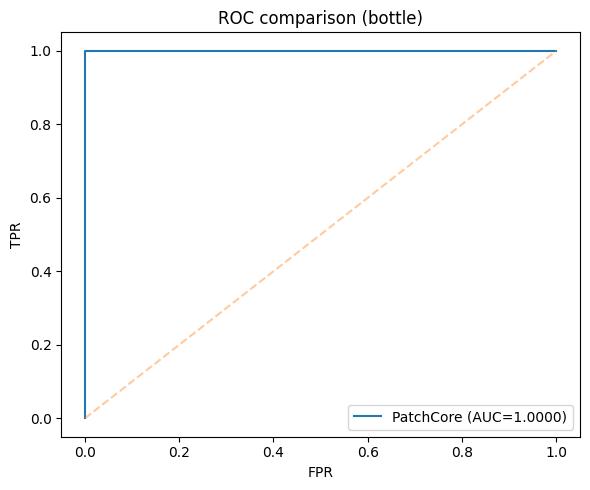

In [4]:
# ===== 追加セルPB：UNet / PaDiM / PatchCore の ROC 比較 =====
import os, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def load_scores_labels(method, class_name):
    """method in {'unet','padim','patchcore'} を想定。保存が無い場合は一部フォールバック。"""
    dir_map = {"unet":"./out_unet_ae", "padim":"./out_padim", "patchcore":"./out_patchcore"}
    sc_path = os.path.join(dir_map[method], f"scores_{class_name}.npy")
    lb_path = os.path.join(dir_map[method], f"labels_{class_name}.npy")
    if os.path.exists(sc_path) and os.path.exists(lb_path):
        sc = np.load(sc_path); lb = np.load(lb_path)
        return sc, lb, f"{method.upper()} (file)"
    # フォールバック（PatchCoreのみ：直近セルのメモリ）
    if method == "patchcore" and 'scores_np' in globals() and 'labels_np' in globals():
        return np.asarray(scores_np), np.asarray(labels_np), "PATCHCORE (mem)"
    return None, None, None

curves = []



# PatchCore
sc_pc, lb_pc, tag_pc = load_scores_labels("patchcore", CLASS_NAME)
if sc_pc is not None:
    fpr_pc, tpr_pc, _ = roc_curve(lb_pc, sc_pc)
    curves.append(("PatchCore", fpr_pc, tpr_pc, auc(fpr_pc, tpr_pc)))
else:
    print("[INFO] PatchCoreのスコアが見つかりません。追加セルPAの保存を実行してください。")

# 描画
if curves:
    plt.figure(figsize=(6,5))
    for name, fpr, tpr, auc_val in curves:
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc_val:.4f})")
    plt.plot([0,1],[0,1],'--',alpha=0.4)
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC comparison ({CLASS_NAME})")
    plt.legend(); plt.tight_layout(); plt.show()
else:
    print("[INFO] 比較可能なメソッドがありません。保存ファイルの有無を確認してください。")
